In [99]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sn
import matplotlib.pyplot as plt

In [100]:
# Choose the path of the data
X_data_path = "data/X_data_10sec.csv"
y_data_path = "data/y_data_10sec.csv"

In [101]:
# Set the parameters
epochs = 16
seconds = "10sec" # length of each sample, this will be used only to name the files with the results

In [102]:
X_data = np.loadtxt(X_data_path, delimiter=",")
X_data.shape

(3000, 38400)

In [103]:
X_data

array([[  0.28048742,   0.81629163,  -6.23892689, ..., -47.85346985,
        -47.85346985, -38.20292664],
       [ -4.82241058,  -6.21592712, -10.80950546, ..., -46.43103409,
        -46.43103409, -46.43103409],
       [  3.79986668,   5.4657836 ,   5.81849146, ..., -49.15478134,
        -49.15478134, -33.45807266],
       ...,
       [-21.03319359, -24.26096344, -23.05108261, ..., -60.63187408,
        -60.63187408, -42.44838333],
       [ -7.60533762, -11.47871494, -10.9920063 , ..., -61.26615906,
        -61.26615906, -43.74389267],
       [ -8.89348984, -21.42334938, -28.44589043, ..., -59.62312698,
        -59.62312698, -44.60402679]])

In [104]:
y_data = np.loadtxt(y_data_path, dtype=str)
y_data.shape

(3000,)

In [105]:
y_data

array(['blues', 'blues', 'blues', ..., 'rock', 'rock', 'rock'],
      dtype='<U9')

In [106]:
labels = np.unique(y_data)
labels

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [107]:
y_data2 = np.zeros((y_data.shape[0], len(labels)))

for i, label in enumerate(labels):
    for j in range(y_data.shape[0]):
        if y_data[j] == label:
            y_data2[j][i] = 1
            
y_data2

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [108]:
X_data2 = X_data.reshape(X_data.shape[0], 128, 300, 1)
X_data2.shape

(3000, 128, 300, 1)

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data2, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 128, 300, 1)
(600, 128, 300, 1)
(2400, 10)
(600, 10)


In [110]:
def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = keras.layers.Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = keras.layers.Dropout(0.4)(x)
    return x

In [112]:
nn_input = keras.Input(shape=(128,300,1))
x = conv_block(nn_input, 16,stride=(2,2))
x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
x = conv_block(x, 64, stride=(2,2))
x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
x = conv_block(x, 256,stride=(2,2))

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', 
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.3)(x)
predictions = keras.layers.Dense(len(labels), 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
model = keras.Model(inputs=nn_input, outputs=predictions)

In [113]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 300, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 300, 16)      160       
                                                                 
 activation_15 (Activation)  (None, 128, 300, 16)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 150, 16)      0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 64, 150, 16)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 150, 32)       4640      
                                                           

In [114]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [115]:
X_train.shape

(2400, 128, 300, 1)

In [116]:
y_train.shape

(2400, 10)

In [117]:
history = model.fit(
      X_train,
      y_train,
      epochs=epochs, 
      batch_size=32,
      validation_split=0.10
        )

Epoch 1/16
68/68 [==============================] - 46s 602ms/step - loss: 7.0210 - accuracy: 0.1347 - val_loss: 4.8070 - val_accuracy: 0.1000
Epoch 2/16
68/68 [==============================] - 40s 591ms/step - loss: 4.5039 - accuracy: 0.1884 - val_loss: 4.4387 - val_accuracy: 0.1208
Epoch 3/16
68/68 [==============================] - 40s 589ms/step - loss: 4.0866 - accuracy: 0.2329 - val_loss: 4.1135 - val_accuracy: 0.1958
Epoch 4/16
68/68 [==============================] - 43s 627ms/step - loss: 3.7587 - accuracy: 0.2750 - val_loss: 3.8074 - val_accuracy: 0.2000
Epoch 5/16
68/68 [==============================] - 41s 599ms/step - loss: 3.4353 - accuracy: 0.3111 - val_loss: 3.6361 - val_accuracy: 0.1875
Epoch 6/16
68/68 [==============================] - 43s 639ms/step - loss: 3.1148 - accuracy: 0.3574 - val_loss: 3.3875 - val_accuracy: 0.2792
Epoch 7/16
68/68 [==============================] - 43s 629ms/step - loss: 2.9163 - accuracy: 0.3611 - val_loss: 3.0951 - val_accuracy: 0.3125

In [118]:
model.save("models/model_" + seconds + "_" + str(epochs) + "epochs")

INFO:tensorflow:Assets written to: models/model_10sec_16epochs\assets


INFO:tensorflow:Assets written to: models/model_10sec_16epochs\assets


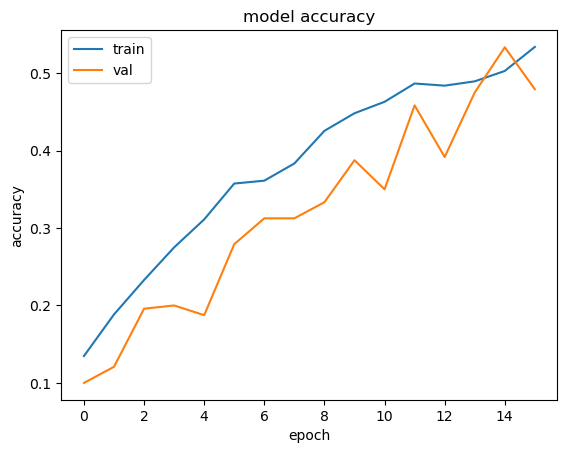

In [119]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("images/accuracy_" + seconds + ".png")
plt.show()

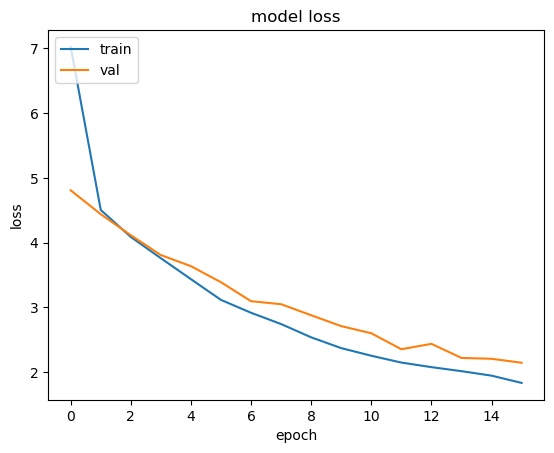

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("images/loss_" + seconds + ".png")
plt.show()

In [121]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 2.154 and val_acc = 0.503


In [122]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred

19/19 [==============================] - 3s 136ms/step
(600, 10)


array([[0.17789559, 0.02123358, 0.10118339, ..., 0.01740611, 0.05513174,
        0.15827347],
       [0.06960672, 0.00981752, 0.04049446, ..., 0.07628245, 0.21662036,
        0.0899236 ],
       [0.11591719, 0.0057603 , 0.03329675, ..., 0.00263677, 0.02730429,
        0.14580388],
       ...,
       [0.11485421, 0.01551628, 0.05465617, ..., 0.01918127, 0.11815794,
        0.13368241],
       [0.1240317 , 0.11246442, 0.19208492, ..., 0.04468948, 0.05261899,
        0.13894847],
       [0.12578385, 0.05137694, 0.19886765, ..., 0.09159107, 0.06402353,
        0.14786112]], dtype=float32)

In [123]:
y_classes = y_pred.argmax(1)
y_classes[:15]

array([0, 4, 6, 7, 3, 9, 0, 3, 0, 0, 5, 9, 6, 2, 5], dtype=int64)

In [124]:
y_test2 = y_test.argmax(1)
y_test2[:15]

array([0, 8, 6, 7, 3, 9, 3, 3, 2, 0, 1, 1, 9, 0, 1], dtype=int64)

In [125]:
import sklearn.metrics as mt

accuracy = mt.accuracy_score(y_test2, y_classes)
precision = mt.precision_score(y_test2, y_classes, average = "macro")
recall = mt.recall_score(y_test2, y_classes, average = "macro")
f1_score = mt.f1_score(y_test2, y_classes, average = "macro")
print("accuracy     : " + str(accuracy))
print("precision    : " + str(precision))
print("recall       : " + str(recall))
print("f1-score     : " + str(f1_score))

accuracy     : 0.5033333333333333
precision    : 0.5565053230533578
recall       : 0.508811996517662
f1-score     : 0.4751419397971503


In [126]:
# model_metrics = {
#     "epochs" : [128],
#     "accuracy" : [accuracy],
#     "precision" : [precision],
#     "recall" : [recall],
#     "f1-score" : [f1_score]
# }
# df_metrics = pd.DataFrame(model_metrics)
# metrics_path = "metrics/metrics_" + seconds + ".csv"
# df_metrics.to_csv(metrics_path, index=False)

In [127]:
metrics_path = "metrics/metrics_" + seconds + ".csv"
df_metrics = pd.read_csv(metrics_path)
df_metrics

,epochs,accuracy,precision,recall,f1-score
0,32.0,0.693333,0.720898,0.693390,0.697194
1,64.0,0.763333,0.780598,0.770911,0.766061
2,128.0,0.830000,0.849458,0.828728,0.830348


In [128]:
model_metrics = {
    "epochs" : epochs,
    "accuracy" : accuracy,
    "precision" : precision,
    "recall" : recall,
    "f1-score" : f1_score
}
df_metrics = df_metrics.append(model_metrics, ignore_index=True)
df_metrics = df_metrics.sort_values(["epochs"])
df_metrics

C:\Users\Utente\AppData\Local\Temp\ipykernel_5996\2179813385.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(model_metrics, ignore_index=True)


,epochs,accuracy,precision,recall,f1-score
3,16.0,0.503333,0.556505,0.508812,0.475142
0,32.0,0.693333,0.720898,0.693390,0.697194
1,64.0,0.763333,0.780598,0.770911,0.766061
2,128.0,0.830000,0.849458,0.828728,0.830348


In [129]:
df_metrics.to_csv(metrics_path, index=False)

In [130]:
cm = mt.confusion_matrix(y_test2, y_classes)
print(cm)

[[25  0 11 10  1  0 11  0  0  2]
 [ 3  6 22  0  0 26  0  0  0  2]
 [11  0 45  1  0  0  0  0  0  3]
 [ 3  0  6 27  5  0  1  8  4  3]
 [ 0  0  0  0 46  0  1  7  2  1]
 [ 8  0 35  1  0  7  3  0  1  5]
 [ 0  0  0  1  0  0 59  0  0  0]
 [ 4  0  2  4  6  0  0 41  0  1]
 [ 3  0  3  6 12  0  2  1 33  1]
 [10  0 20  6  1  0 13  2  3 13]]


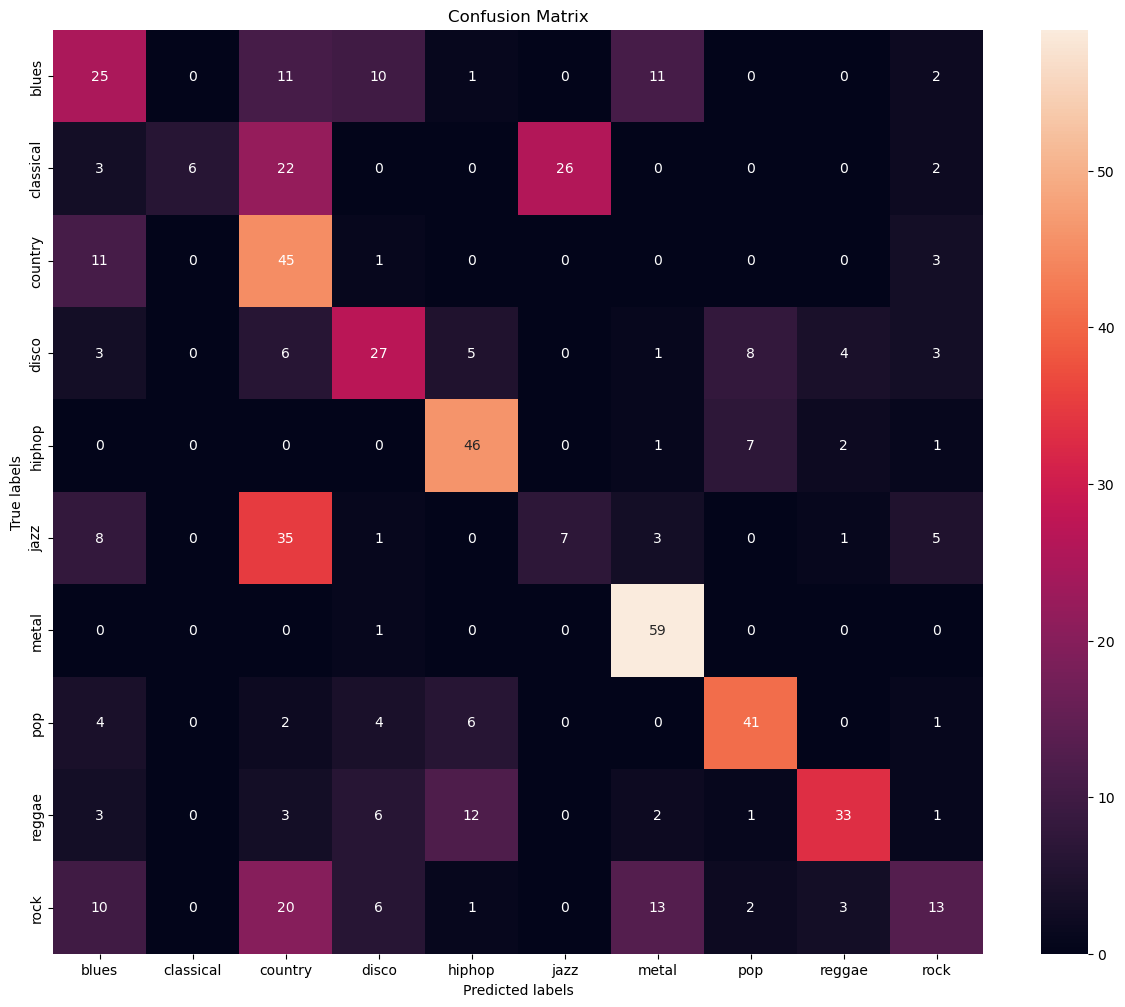

In [131]:
plt.figure(figsize=(15,12))
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.savefig("images/" + seconds + "/confusion_matrix_" + str(epochs) + "epochs.png")